In [1]:
from utils import (train_epoch, eval_model, train_model, load_dataset,
                   plot_training_curves, show_samples)
from VampPrior import VampPrior
import torch
import numpy as np
import os
from tqdm.auto import tqdm

In [2]:
device = 'cuda'
IMG_SIZE = (3, 32, 32)
num_params = 1024
model_dict = dict(num_params = num_params,
                 in_shape = IMG_SIZE,
                 n_latent_coarse = 40,
                 n_latent_fine = 40,
                 device = device,
                 hidden_dim_img_vec = 300,
                 hidden_dim_mlp = 300,
                  beta = 1.)

model = VampPrior(**model_dict).to(device)

# for finetuning
ckpt_files = [file for file in os.listdir(os.getcwd()) if file.endswith('.ckpt')]
if ckpt_files:
  model.load_state_dict(torch.load(ckpt_files[0], map_location=device))

# path = '/content/VampPrior_lr_1e-05_n_epochs_10_num_params_1000_finetuned.ckpt'
# model.load_state_dict(torch.load(path, map_location=device))

In [3]:
train_loader, test_loader = load_dataset(img_size = IMG_SIZE, batch_size = 128, num_workers = 1, name="MNISTcolored")

100%|██████████| 9912422/9912422 [00:00<00:00, 157495686.20it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41371480.13it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39941850.06it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3340439.90it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [4]:
# prior params could be initialized as samples from the dataset
prior_par = None
for i, (b, _) in enumerate(train_loader):
  if i == 8:
    break
  if prior_par is None:
    prior_par = b
  else:
    prior_par = torch.cat([prior_par, b])
model.prior_params = torch.nn.Parameter(prior_par)

100%|██████████| 30/30 [1:02:28<00:00, 124.96s/it]


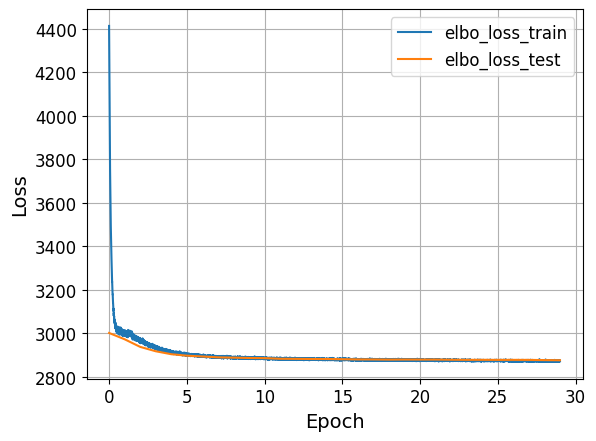

In [5]:
lr = 1e-4
n_epochs = 30
train_dict = dict(model=model,
                  train_loader=train_loader,
                  test_loader=test_loader,
                  epochs=n_epochs,
                  lr=lr,
                  use_tqdm=True,
                  use_cuda=True)

train_losses, test_losses = train_model(**train_dict)
plot_training_curves(train_losses, test_losses)

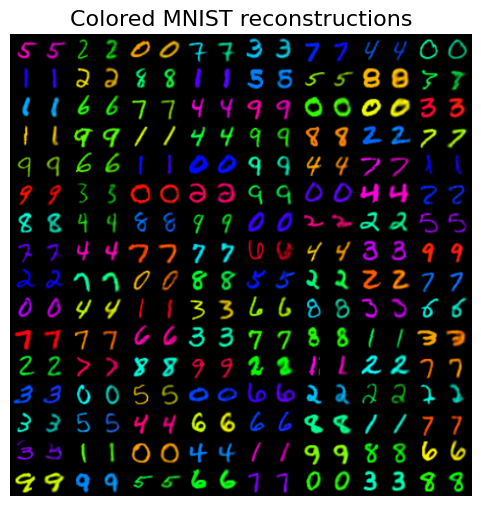

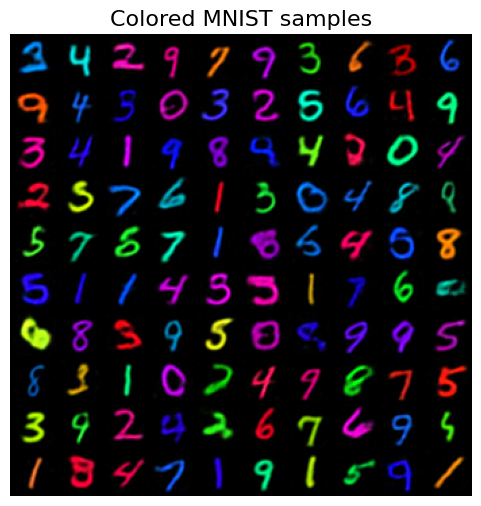

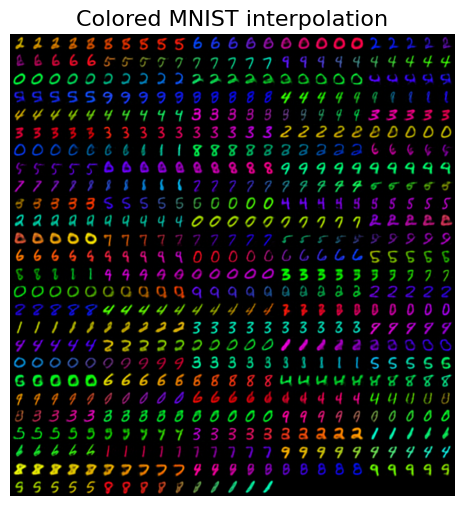

In [6]:
model.eval()
samples = model.sample(100)
USE_CUDA = device == 'cuda'
x, _ = next(iter(test_loader))[:50]
if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z = model.encoder(x)[0]
    x_recon = torch.clamp(model.decoder(z)[0], -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, *IMG_SIZE) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()

x, _ = next(iter(test_loader))[:20]
if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z = model.encoder(x)[0]
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha)[0] for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, *IMG_SIZE)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()

show_samples(reconstructions, 'Colored MNIST reconstructions')
show_samples(samples, 'Colored MNIST samples')
show_samples(interps, 'Colored MNIST interpolation')

  0%|          | 0/10000 [00:00<?, ?it/s]

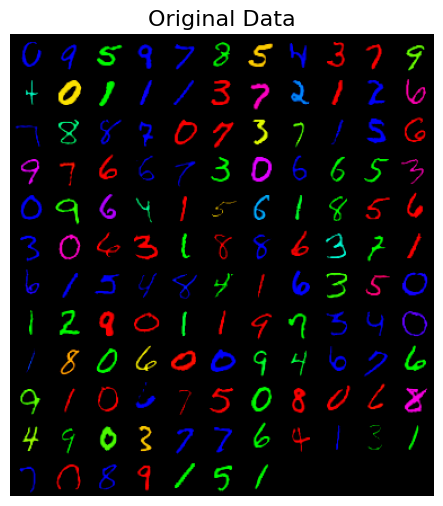

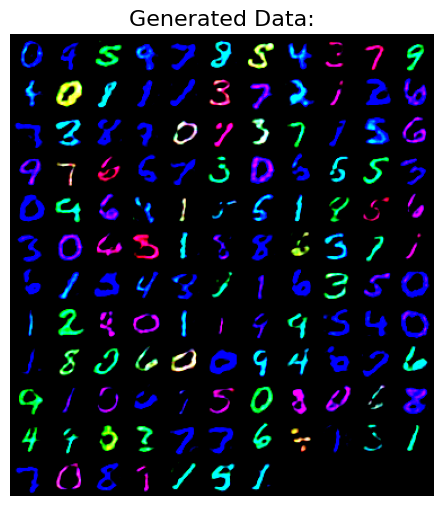

In [14]:
import torch.nn.functional as F
model.eval()

USE_CUDA = device

# Set parameters
learning_rate = 0.0001
epsilon_std = 1
num_iterations = 10000

Pdata, _ = next(iter(test_loader))
if USE_CUDA:
    Pdata = Pdata.cuda()

# Step 1: Run the encoder (ConvVAE)
z0 = model.encoder(Pdata)[0]
# z0 = model.prior(128)
z0 = z0.to(device)

# Step 2: Run Langevin dynamics with ConvVAE
zt = z0.clone()
for _ in tqdm(range(num_iterations)):
    zt = zt + learning_rate * zt + np.sqrt(learning_rate) * torch.randn_like(zt)

# Step 3: Decode to obtain generated data
reconstructed_data = torch.clamp(model.decoder(zt)[0], -1, 1)

# Print the results
show_samples(Pdata.detach().cpu().numpy(), 'Original Data')
show_samples(reconstructed_data.detach().cpu().numpy(), 'Generated Data:')

In [8]:
torch.save(model.state_dict(), f'./VampPrior_lr_{lr}_n_epochs_{n_epochs}_num_params_{num_params}.ckpt')
# model = VampPrior(**model_dict)
# model.load_state_dict(torch.load('/content/VampPrior_large.ckpt'))
# model = model.to(device)
# model.eval()